In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Previsão de Série Temporal da Temperatura de Mancais Utilizando LSTM


## Parte 0 - Importação das Bibliotecas

In [ ]:
#%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import math


from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

#tf.__version__

## Parte 1 - Importação do Dataset e Estatística Descritiva

In [ ]:
# Importação da Base de Dados
#dataset = pd.read_csv('/content/drive/MyDrive/BI_MASTER/PROJETO_FINAL_BIMASTER/DATASETS/dataset_GE-4100_12001B.csv')
dataset = pd.read_csv('/content/drive/MyDrive/BI_MASTER/PROJETO_FINAL_BIMASTER/DATASETS/dataset_C-4451_08001A.csv')

# Eliminando as TAGs que não se referem aos mancais do equipamento
#dataset = dataset[dataset.MANCAL != 'ECE1.G2-TI-MANCD.F_CV']
#dataset = dataset[dataset.MANCAL != 'ECE1.G2-TI-MANCT.F_CV']

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2245 entries, 0 to 2244
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   EQUIPAMENTO  2245 non-null   object 
 1   MANCAL       2245 non-null   object 
 2   DATA         2245 non-null   object 
 3   TEMPERATURA  2245 non-null   float64
dtypes: float64(1), object(3)
memory usage: 70.3+ KB


In [ ]:
dataset.head()

,EQUIPAMENTO,MANCAL,DATA,TEMPERATURA
0,C-4451.08001A,EJA1.A-TC21.F_CV,04/01/2021,69.88962
1,C-4451.08001A,EJA1.A-TC21.F_CV,05/01/2021,69.59235
2,C-4451.08001A,EJA1.A-TC21.F_CV,06/01/2021,69.56962
3,C-4451.08001A,EJA1.A-TC21.F_CV,07/01/2021,67.57046
4,C-4451.08001A,EJA1.A-TC21.F_CV,15/01/2021,69.05307


In [ ]:
#Conversão do campo data para datetime e ordenação do dataset
dataset['DATA'] = pd.to_datetime(dataset['DATA'],dayfirst=True)
dataset = dataset.sort_values(['EQUIPAMENTO', 'MANCAL', 'DATA'], ascending=[1, 1, 1])
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2245 entries, 0 to 2244
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   EQUIPAMENTO  2245 non-null   object        
 1   MANCAL       2245 non-null   object        
 2   DATA         2245 non-null   datetime64[ns]
 3   TEMPERATURA  2245 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 87.7+ KB


In [ ]:
dataset.groupby(['EQUIPAMENTO','MANCAL']).count()

DATA  TEMPERATURA
EQUIPAMENTO   MANCAL                                
C-4451.08001A EJA1.A-TC21.F_CV      132          132
              EJA1.A-TC22.F_CV      132          132
              EJA1.A-TC23.F_CV      132          132
              EJA1.A-TC25.F_CV      132          132
              EJA1.A-TC250.F_CV     133          133
              EJA1.A-TC251.F_CV     132          132
              EJA1.A-TC26.F_CV      132          132
              EJA1.A-TC27.F_CV      132          132
              EJA1.A-TC28.F_CV      132          132
              EJA1.A-TE1200A.F_CV   132          132
              EJA1.A-TE1200B.F_CV   132          132
              EJA1.A-TE1203A.F_CV   132          132
              EJA1.A-TE1203B.F_CV   132          132
              EJA1.A-TE1206A.F_CV   132          132
              EJA1.A-TE1206B.F_CV   132          132
              EJA1.A-TE1209A.F_CV   132          132
              EJA1.A-TE1209B.F_CV   132          132

In [ ]:
#Separação do dataset por mancais
mancais = dataset['MANCAL'].unique().tolist()

manc1 = dataset[dataset['MANCAL'] == mancais[0]]
manc2 = dataset[dataset['MANCAL'] == mancais[1]]
manc3 = dataset[dataset['MANCAL'] == mancais[2]]
manc4 = dataset[dataset['MANCAL'] == mancais[3]]
manc5 = dataset[dataset['MANCAL'] == mancais[4]]
manc6 = dataset[dataset['MANCAL'] == mancais[5]]
manc7 = dataset[dataset['MANCAL'] == mancais[6]]

#Criação do dataframe com as datas registradas para pelo menos um dos mancais
lista_datas = dataset['DATA'].unique().tolist()
datas_registradas = pd.DataFrame(lista_datas,columns=['DATA'])
datas_registradas['DATA'] = pd.to_datetime(datas_registradas['DATA'],dayfirst=True)


In [ ]:
# Ajuste dos datasets para incluir datas faltantes do conjunto e preencher os 
# dados faltantes. A temperatura será preenchida com a moda do conjunto de 
# temperaturas do mancal.
def completeDates( dates, dataset ):
  result = pd.merge(dates, dataset, on='DATA', how='outer')
  result['EQUIPAMENTO'].fillna(np.array(dataset['EQUIPAMENTO'])[0], inplace = True);
  result['MANCAL'].fillna(np.array(dataset['MANCAL'])[0], inplace = True);
  result['TEMPERATURA'].fillna(np.array(manc3['TEMPERATURA'].mode())[0], inplace = True)
  return result

#manc1 = completeDates( datas_registradas, manc1)
#manc1 = completeDates( datas_registradas, manc2)
#manc3 = completeDates( datas_registradas, manc3)
#manc4 = completeDates( datas_registradas, manc4)
#manc5 = completeDates( datas_registradas, manc5)
#manc6 = completeDates( datas_registradas, manc6)
#manc7 = completeDates( datas_registradas, manc7)

In [ ]:
dataset.describe()

,TEMPERATURA
count,2245.000000
mean,64.265038
std,16.315631
min,18.718320
25%,54.898560
50%,59.504080
75%,71.582280
max,390.441750


#### Análise Gráfica

No handles with labels found to put in legend.


Text(0.5, 0, 'Temperatura')

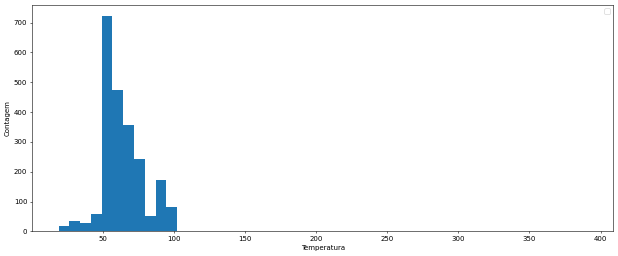

In [ ]:
temperaturas = dataset.to_numpy()
temperaturas = temperaturas[:,3:4]
bins = np.linspace(temperaturas.min(), temperaturas.max(), 50)
plt.figure(figsize=(15, 6), dpi=50)
plt.hist(temperaturas, bins=bins)
plt.legend()
plt.ylabel('Contagem')
plt.xlabel('Temperatura')

Text(0.5, 0, 'Temperatura')

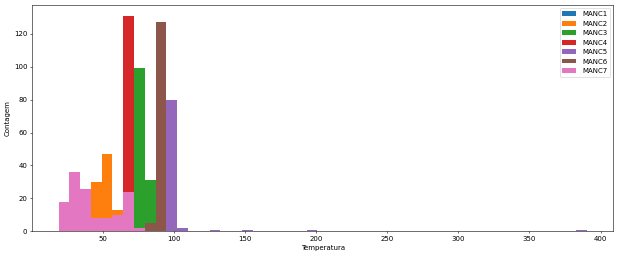

In [ ]:
tempsManc1 = manc1.to_numpy()[:,3:4]
tempsManc2 = manc2.to_numpy()[:,3:4]
tempsManc3 = manc3.to_numpy()[:,3:4]
tempsManc4 = manc4.to_numpy()[:,3:4]
tempsManc5 = manc5.to_numpy()[:,3:4]
tempsManc6 = manc6.to_numpy()[:,3:4]
tempsManc7 = manc7.to_numpy()[:,3:4]

plt.figure(figsize=(15, 6), dpi=50)
plt.hist(tempsManc1, bins=bins, label='MANC1')
plt.hist(tempsManc2, bins=bins, label='MANC2')
plt.hist(tempsManc3, bins=bins, label='MANC3')
plt.hist(tempsManc4, bins=bins, label='MANC4')
plt.hist(tempsManc5, bins=bins, label='MANC5')
plt.hist(tempsManc6, bins=bins, label='MANC6')
plt.hist(tempsManc7, bins=bins, label='MANC7')
plt.legend()
plt.ylabel('Contagem')
plt.xlabel('Temperatura')

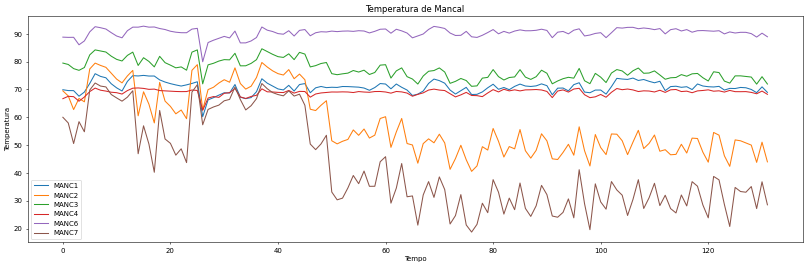

In [ ]:
plt.figure(figsize=(20, 6), dpi=50)

plt.plot(tempsManc1, label='MANC1')
plt.plot(tempsManc2, label='MANC2')
plt.plot(tempsManc3, label='MANC3')
plt.plot(tempsManc4, label='MANC4')
#plt.plot(tempsManc5, label='MANC5')
plt.plot(tempsManc6, label='MANC6')
plt.plot(tempsManc7, label='MANC7')

plt.xlabel("Tempo")
plt.ylabel("Temperatura")
plt.title("Temperatura de Mancal")
plt.legend()
plt.show()

## Parte 2 - Preprocessamento de Dados

### Separação do conjunto de Treino e Teste

In [ ]:
datasetMancal = manc3
#Conversão das temperaturas para número inteiro. Teste para ver se ajuda a RN. 
#datasetMancal = datasetMancal.astype({"TEMPERATURA": int})
#datasetMancal['TEMPERATURA'] = datasetMancal['TEMPERATURA'].round(decimals=1)

#Calculando tamanho dos conjuntos de treino e teste
train_size = math.ceil(len(datasetMancal)*0.85)
test_size  = len(datasetMancal) - train_size

#Separando conjuto de treino e teste apenas com valor da série
train_set = datasetMancal.iloc[0:train_size, 3:4].values
test_set  = datasetMancal.iloc[train_size:(train_size + test_size), 3:4].values

### gráfico da série temporal

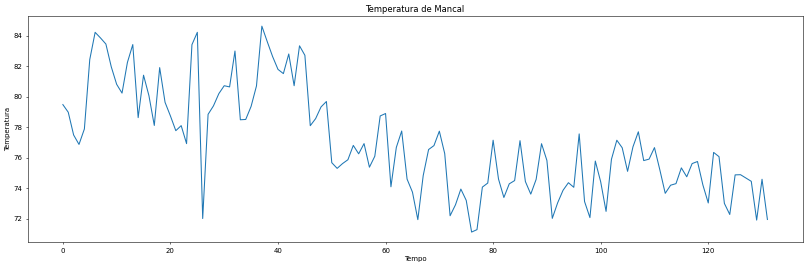

In [ ]:
plt.figure(figsize=(20, 6), dpi=50)

plt.plot(datasetMancal.iloc[0:len(datasetMancal), 3:4].values)
plt.xlabel("Tempo")
plt.ylabel("Temperatura")
plt.title("Temperatura de Mancal")
plt.show()

### Normalização

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train_set)

### Criar a estrutura de dados com janela WINDOW e output OUTPUTSIZE para entrada na RN

In [ ]:
def prepareSetRN(windowSize, outputSize, flatSet ):
  preparedX = []
  preparedY = []
  setSize = len(flatSet)
  for i in range(windowSize, setSize - (outputSize-1)):
    preparedX.append(flatSet[i-windowSize:i, 0])
    preparedY.append(flatSet[i:i + outputSize, 0])

  preparedX, preparedY = np.array(preparedX), np.array(preparedY)
  return preparedX, preparedY

## Parte 3 - Construção da RNN

##### Parâmetros para geração das redes

In [ ]:
#windowSet   = [4]
#outputSet   = [3]
#layerSet    = [1]
#unitSet     = [[150,80,80]]
#dropoutSet  = [0.25] 
#optmizerSet = ['Adam']
#epochs      = 100
#batch_size  = 20

windowSet   = [3,4,5,6]
outputSet   = [2,3]
layerSet    = [1,2,3]
unitSet     = [[150,80,80],[120,60,40],[80,80,60]]
dropoutSet  = [0.2, 0.25, 0.3, 0.35] 
optmizerSet = ['Adam', 'Adadelta']
epochs      = 800
batch_size  = 32

#windowSet   = [6,7,8,9,10,11,12]
#outputSet   = [2,3]
#layerSet    = [1,2,3]
#unitSet     = [80,100,120,150]
#dropoutSet  = [0, 0.2, 0.25, 0.3, 0.35] 
#optmizerSet = ['SGD','RMSprop', 'Nadam', 'Adamax']

### Construção da Rede completa

In [ ]:
def criaRN(outputParam, layerParam, unitParam, dropoutParam, optmizerParam, X_trainParam):
  # Inicializar a RNN
  regressor = Sequential()

  # Adicionar a primeira camada LSTM e Dropout 
  regressor.add(LSTM(units = unitParam[0], return_sequences = (layerParam > 1), input_shape = (X_trainParam.shape[1], 1)))
  regressor.add(Dropout(dropoutParam))
 
  if ( layerParam >= 2 ):
    # Adicionar a segunda camada LSTM e Dropout
    regressor.add(LSTM(units = unitParam[1], return_sequences = (layerParam > 2)))
    regressor.add(Dropout(dropoutParam))

  if ( layerParam >= 3):
    # Adicionar a terceira camada LSTM e Dropout
    regressor.add(LSTM(units = unitParam[2], return_sequences = (layerParam > 3)))
    regressor.add(Dropout(dropoutParam))

  # camada de saída
  regressor.add(Dense(units = outputParam, activation='linear'))
  #Testar sigmoid e linear

  # Compilar a rede
  regressor.compile(optimizer = optmizerParam, loss = 'mean_squared_error', metrics=['accuracy'])

  # Visualizar a rede
  #regressor.summary()

  return regressor


In [ ]:
def backToFlat( windowSet ):
    flatSet     = []
    window_size = windowSet.shape[1]
    setSize     = len(windowSet)

    #Adiciona as primeiras colunas do primeiro registro quando a janela > 1
    if window_size > 1:
      for i in range(0, window_size-1):
        flatSet.append(windowSet[0, i])

    for i in range(0, setSize):
        flatSet.append(windowSet[i, window_size-1])

    flatSet = np.array(flatSet)

    return np.reshape(flatSet, (flatSet.shape[0], 1)) 

In [ ]:
fResults = open("resultados.csv","w+")

fResults.write("EQUIPAMENTO,MANCAL,WINDOW,OUTPUT,NUM. CAMADAS,NUM. NEURONIOS CAMADA 1,NUM. NEURONIOS CAMADA 2,NUM. NEURONIOS CAMADA 3,DROUPOUT,OTIMIZADOR,EPOCHS,BATCH_SIZE,RMSE,MSE,MAPE\r\n" )

for a in range(0, len(windowSet) ):
  for b in range(0, len(outputSet) ):
    for c in range(0, len(layerSet) ):
      for d in range(0, len(unitSet) ):
        for e in range(0, len(dropoutSet) ):
          for f in range(0, len(optmizerSet) ):
            X_train = []
            y_train = []
            X_train, y_train = prepareSetRN(windowSet[a], outputSet[b], training_set_scaled)
            X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

            regressor = criaRN(outputSet[b], layerSet[c], unitSet[d], dropoutSet[e], optmizerSet[f], X_train)
            history = regressor.fit(X_train, y_train, epochs = epochs, batch_size = batch_size)
            
            #Acréscimo da janela no conjunto de teste para pegar os últimos registros do treino
            test_set_first_window  = dataset.iloc[train_size - windowSet[a]:(train_size + test_size), 3:4].values

            test_set_scaled = sc.transform(test_set_first_window)

            X_test = []
            y_test = []

            X_test, y_test = prepareSetRN(windowSet[a], outputSet[b], test_set_scaled)
            X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

            predicted = regressor.predict(X_test)
            predicted = sc.inverse_transform(predicted)

            test_predicted = backToFlat(predicted)

            rmse = math.sqrt(mean_squared_error(test_set, test_predicted))
            mse = mean_squared_error(test_set, test_predicted)
            mape = np.mean(np.abs((test_set - test_predicted) / test_set)) * 100

            fResults.write("%s," % datasetMancal['EQUIPAMENTO'].to_numpy()[0])
            fResults.write("%s," % datasetMancal['MANCAL'].to_numpy()[0])
            fResults.write("%d," % windowSet[a])
            fResults.write("%d," % outputSet[b])
            fResults.write("%d," % layerSet[c])
            fResults.write("%d," % unitSet[d][0])
            fResults.write("%d," % unitSet[d][1])
            fResults.write("%d," % unitSet[d][2])
            fResults.write("%f," % dropoutSet[e])
            fResults.write("%s," % optmizerSet[f])
            fResults.write("%d," % epochs)
            fResults.write("%d," % batch_size)
            fResults.write("%f," % rmse)
            fResults.write("%f," % mse)
            fResults.write("%f\r\n" % mape)

fResults.close()                    